# Visualising the data

In this notebook, we will guide you through visualising the data you downloaded through the API in the form of graphs. In the process we introduce ```pandas```, a very popular data processing library. Entire books have been written on the  ```pandas``` library, and there is an extensive online [documentation](https://pandas.pydata.org/docs/); in this notebook, we will restrict ourselves to the minimum required to use the library as a wrapper for ```matplotlib```, a lower-level data visualisation library.

Both ```pandas``` and ```matplotlib``` are installed on the EECS JupyterHub server, and they are likely to be part of any major Python distribution, so the following ```import``` statements should just work. Installation instructions for [pandas](https://pandas.pydata.org/docs/getting_started/install.html) and [matplotlib](https://matplotlib.org/users/installing.html) are available online.

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import json

In [10]:
# an iPython  "magic" that enables the embedding of matplotlib output
%matplotlib inline
# make figures larger
plt.rcParams['figure.dpi'] = 100

## Time series data

We start by loading the data from the JSON file in which we saved it. Reading a JSON file in Python is not any more difficult than writing it:

In [20]:
with open("timeseries.json", "rt") as INFILE:
    data=json.load(INFILE)

In [ ]:
data

### Wrangling the data

Whatever your query, the data is unlikely to come in a form that's amenable to be plotted directly; some wrangling, munging, or other bit of cool data science jargon is required. Our aim is to extract values for the *x* axis of our plot (in this case the dates). These will become the *index* of a ```DataFrame```, of which the *columns* will contain the data proper. You can, for the moment, think of a ```DataFrame``` as the Python equivalent of an Excel spreadsheet.

As we can see, the data consists of a dictionary; actual data is stored as a list of dictionaries under the ```data``` key. Let us start by retrieving that:

In [ ]:
datalist=data['data']
datalist

We then want to extract all the dates and sort them. Luckily, with dates written year-first, alphabetical ordering does the trick.

In [ ]:
dates=[dictionary['date'] for dictionary in datalist ]
dates.sort()
dates

Do not assume this is a proper time series: on occasion, I found some dates to be duplicated - a quick check showed they contained the same values. Also, some dates may be missing. At any rate, we find the earliest and latest date and convert them to the ```pandas``` type for representing dates.

In [23]:
def parse_date(datestring):
    """ Convert a date string into a pandas datetime object """
    return pd.to_datetime(datestring, format="%Y-%m-%d")

In [ ]:
startdate=parse_date(dates[0])
enddate=parse_date(dates[-1])
print (startdate, ' to ', enddate)

We are now ready to define our ```DataFrame```. To start with, we create an index as a ```date_range```: this is the date analog of a ```range``` for integers, and it will include any dates that may be missing from our list.
We then proceed to define the ```DateFrame``` by specifying its index and the title of its columns.

In [ ]:
index=pd.date_range(startdate, enddate, freq='D')
timeseriesdf=pd.DataFrame(index=index, columns=['cases', 'hospital', 'deaths'])
timeseriesdf

As you can see, the ```DataFrame``` resembles a spreadsheet, or if you want a matrix with labels. We now proceed to fill it in with values from our three statistics. Note that there are many ways of filling in a ```DataFrame```: this is probably not the most efficient, but it is in my view the easiest to understand and one of those that give you more control over the values you enter.

In [ ]:
for entry in datalist: # each entry is a dictionary with date, cases, hospital and deaths
    date=parse_date(entry['date'])
    for column in ['cases', 'hospital', 'deaths']:
        # check that nothing is there yet - just in case some dates are duplicated,
        # maybe with data for different columns in each entry
        if pd.isna(timeseriesdf.loc[date, column]): 
            # replace None with 0 in our data 
            value= float(entry[column]) if entry[column]!=None else 0.0
            # this is the way you access a specific location in the dataframe - use .loc
            # and put index,column in a single set of [ ]
            timeseriesdf.loc[date, column]=value
            
# fill in any remaining "holes" due to missing dates
timeseriesdf.fillna(0.0, inplace=True)
            
timeseriesdf

### Plotting

Creatimg a basic plot of our data is now dead easy. We just need to call the ```plot()``` method on our ```DataFrame```; this will call the underlying ```matplot.pyplot``` functions to create a plot of the data. For more options and fancier graphs, see the [documentation](https://pandas.pydata.org/pandas-docs/stable/user_guide/visualization.html).

In [ ]:
timeseriesdf.plot() # easy peasy...

After lording it for centuries over engineering calculations up to the advent of computers, logarithms had never been so popular as they have become since the rise of Covid dashboards - now everybody and their uncle knows what a log scale is. There is a reason for that: exponential phenomena are well suited for plotting on log scales, where an exponential propagation becomes a straight line. You wouldn't want to miss out on this centuries-old fad:

In [ ]:
timeseriesdf.plot(logy=True) # ...lemon squeezy

## Age distribution data

As a second example, let's plot age distribution data. The data scructure, as you can see, is rather different, so this will be another good exercise in data wrangling.

In [11]:
with open("agedistribution.json", "rt") as INFILE:
    data=json.load(INFILE)

In [ ]:
data

### Data munging



Once again, there are no fixed rules for this - just see in what format your data comes, have clear in your mind what you are aiming for, and wrangle your data accordingly. In this case, we want to get to a ```DataFrame``` with the age bins as an *index*, and values for males and females as its *columns*.

In this case, the ```'data'``` corresponds to a list, of which the first and only element is a dictionary. Let's try to get hold of that dictionary:

In [ ]:
datadic=data['data'][0] # data['data'] is a list
datadic

This already looks better. We can now grab the lists of entries for males and females separately:

In [ ]:
males=datadic['males']
females=datadic['females']
males # females is similar 

Age bands are the same in both cases, so we can just extract them from one list:

In [ ]:
ageranges=[x['age'] for x in males] # each entry of males is a dictionary
print(ageranges)

This is great, but we would like our dataframe *index* to be nicely sorted. The lower limit of the age bands looks like a suitable candidate for a sort key, let's try to extract it...

In [ ]:
def min_age(agerange):
    agerange=agerange.replace('+','') # remove the + from 90+
    start=agerange.split('_')[0]
    return int(start)

print(min_age('85_to_89'))
print(min_age('90+')) # looking good...

We can now use the ```min_age``` function as a *key* for the ```sort()``` function (see the [Sorting HOWTO](https://docs.python.org/3/howto/sorting.html) for details): 

In [ ]:
ageranges.sort(key=min_age)
print (ageranges)

We are finally ready to define our ```DataFrame```. We use ```ageranges``` as an *index*, and include *columns* for males and females. We also add a *total* column that we will compute from the other two:

In [17]:
age_df=pd.DataFrame(index=ageranges, columns=['males','females', 'total'])

Filling in ```age_df``` is only a matter of looping separately over the values for males and females and assigning each value to the corresponding age band and column. Finally, we compute the *total* column as the sum of the *males* and *females* columns (another handy ```DataFrame``` feature).

In [18]:
for entry in males: # each entry is a dictionary
    ageband=entry['age'] # our index position
    age_df.loc[ageband, 'males']=entry['value']
    
for entry in females:
    ageband=entry['age']
    age_df.loc[ageband, 'females']=entry['value']
    
# this is straightforward
age_df['total']=age_df['males']+age_df['females']

In [ ]:
age_df

### Plotting

For fancier bar plots, see this [tutorial](https://www.shanelynn.ie/bar-plots-in-python-using-pandas-dataframes/).

In [ ]:
age_df.plot(kind='bar', y=['males','females'])

In [ ]:
age_df.plot(kind='bar', y='total')

## How to get ~~yourself~~ your data in a pickle [file]

In the actual dashboard, at this point, there is no need to save the dataframes - you can just add interactive controls to the graphs as you plot them. While developing, however, we want to save the wrangled data in order to be able to experiment with the controls. Pandas luckily makes it easy by providing a method that saves a ```DataFrame``` to a "pickle" file. This is based on the ```pickle``` [library](https://docs.python.org/3/library/pickle.html), that however is imported by ```pandas```, so you do not need to import it yourself. While JSON is a standard format that is language-independent, a *pickle* file is Python-specific. This format is thus more flexible, allowing the [serialisation](https://en.wikipedia.org/wiki/Serialization) of a broader range of Python objects; however, it is less portable.

In [30]:
# pandas makes saving to a pickle file dead easy:
timeseriesdf.to_pickle("timeseriesdf.pkl")
age_df.to_pickle("agedf.pkl")

## Your turn

Load the data you saved in the JSON files, munge it, turn it into a ```DataFrame``` and display it; then save your ```DataFrame``` to a *pickle* file. In the next notebook, when we will show you how to add interactive controls to your graphs. 

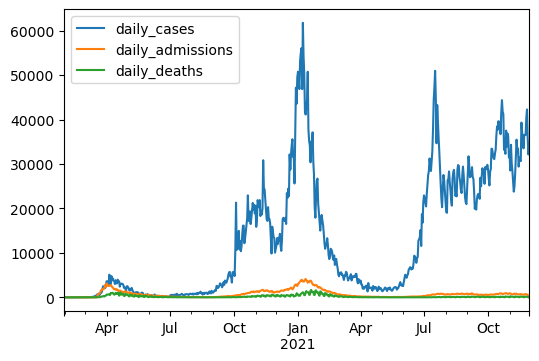

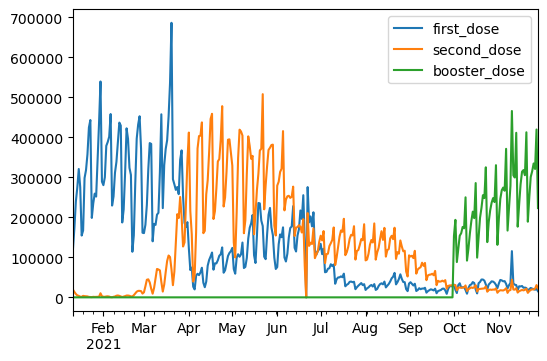

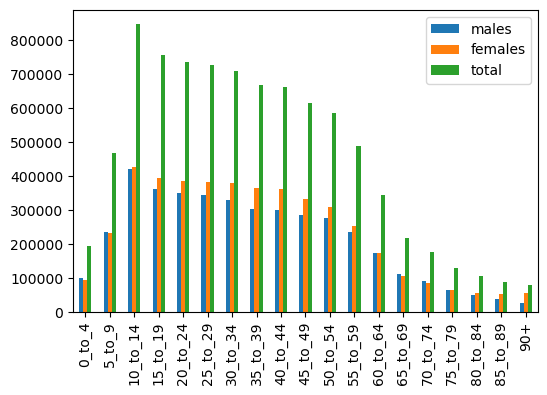

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import json

# an iPython  "magic" that enables the embedding of matplotlib output
%matplotlib inline
# make figures larger
plt.rcParams['figure.dpi'] = 100

trends = ['case_trend_data', 'vaccination_trend_data']

def get_trend_data(trend_data):
    with open(f"{trend_data}.json") as INFILE:
        trend_data = json.load(INFILE)
        dates = [grp['date'] for grp in trend_data['data']]
        dates.sort()
        return [trend_data, dates]

def parse_date(dates_tring):
    return pd.to_datetime(dates_tring, format = "%Y-%m-%d")

def gen_trend_df(trend_data):
    data = get_trend_data(trend_data)
    start_date = parse_date(data[1][0])
    end_date = parse_date(data[1][-1])
    index = pd.date_range(start_date, end_date, freq='D')
    columns = [column for column in data[0]['data'][0].keys()]
    columns.pop(0)
    df = pd.DataFrame(index = index, columns = columns)
    for grp in data[0]['data']:
        date = parse_date(grp['date'])
        for column in columns:
            if pd.isna(df.loc[date, column]):
                value= float(grp[column]) if grp[column]!= None else 0.0
                df.loc[date, column] = value
    df.fillna(0.0, inplace=True)
    df.plot()
    return df

def gen_age_distribution_df(distribution_data):
    with open(f"{distribution_data}.json") as INFILE:
        distribution_data = json.load(INFILE)
    latest_distribution_data = distribution_data['data'][0]
    males = latest_distribution_data['males']
    females = latest_distribution_data['females']
    age_ranges = [entry['age'] for entry in males]
    def min_age(age_range):
        age_range = age_range.replace('+','')
        start = age_range.split('_')[0]
        return int(start)
    age_ranges.sort(key=min_age)
    df = pd.DataFrame(index = age_ranges, columns = ['males', 'females', 'total'])
    for entry in males:
        age_band = entry['age']
        df.loc[age_band, 'males'] = entry['value']
    for entry in females:
        age_band = entry['age']
        df.loc[age_band, 'females'] = entry['value']
    df['total'] = df['males'] + df['females']
    df.plot(kind = 'bar', y = ['males', 'females', 'total'])
    return df

case_trend_df = gen_trend_df(trends[0])
vaccination_trend_df = gen_trend_df(trends[1])
age_distribution_df = gen_age_distribution_df('age_distribution_data')

case_trend_df.to_pickle("case_trend_df.pkl")
vaccination_trend_df.to_pickle("vaccination_trend_df.pkl")
age_distribution_df.to_pickle("age_distribution_df.pkl")


            
    




**(C) 2020 Fabrizio Smeraldi** ([f.smeraldi@qmul.ac.uk](mailto:f.smeraldi@qmul.ac.uk) - [web](http://www.eecs.qmul.ac.uk/~fabri/)), all rights reserved.